<span style="color:red;">GNN-based molecular property prediction

A GNN is a neural network designed to operate on graph-structured data, andolecules are naturally represented as graphs where atoms are nodes and bonds are edges. \
Each node and edge can have features.\
 The GNN learns by passing messages between neighboring nodes (atoms), gradually learning a graph-level representation (i.e., for the whole molecule).\
Use RDKit to convert SMILES into graphs:\
Nodes = atoms with features \
Edges = chemical bonds between atoms\
Graph label = whether molecule crosses blood-brain barrier

Aim:\
Use the built-in MoleculeNet BBBP graph dataset
Train a simple GCN-based GNN
Print test accuracy\

GCN (Graph Convolutional Network).\
GCN sums over all neighbors of node, including the node itself and aggregate all information. It's the simplest GNN, using a mean-based aggregation.
Basic vs Deep GCN: see what happens using more layers and wider hidden dimensions.
 

GAT (Graph Attention Network):
GAT uses attention mechanism to weight neighbor contributions
Learns which neighbors are more important for each node
More flexible than GCN but computationally heavier

 Graph Isomorphism Network (GIN):
 GIN has been proposed to overcome the disadvantages of GCNs. GIN is based on the Weisfeiler-Lehman graph isomorphism test. 

| Model          | Key Idea                             | Pros                               | Cons                      |
| -------------- | ------------------------------------ | ---------------------------------- | ------------------------- |
| **GCN\_Basic** | Mean aggregation (2 layers)          | Fast, simple baseline              | Limited capacity          |
| **GCN\_Deep**  | Deeper GCN (4 layers)                | More expressive                    | Risk of over-smoothing    |
| **GAT**        | Attention-weighted neighbors         | Learns importance of each neighbor | Slower, higher memory     |
| **GIN**        | MLP-based, strong structure learning | High expressive power              | Complex, heavier training |


Reference:\
paper doi: 10.1186/s13321-020-00479-8\
tutorial https://projects.volkamerlab.org/teachopencadd/talktorials/T035_graph_neural_networks.html

In [7]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (
    GCNConv, GATConv, GINConv,
    global_mean_pool, global_max_pool, global_add_pool
)
import random
import os


Number of node features: 9
Number of edge features: 3
Number of classes: 2

 Training GCN_Basic...
   Early stopping at epoch 76 (Best epoch: 46)
   GCN_Basic Test ROC-AUC: 0.8798 (Best epoch: 46)

 Training GCN_Deep...
   Early stopping at epoch 72 (Best epoch: 42)
   GCN_Deep Test ROC-AUC: 0.8939 (Best epoch: 42)

 Training GAT...
   Early stopping at epoch 63 (Best epoch: 33)
   GAT Test ROC-AUC: 0.9014 (Best epoch: 33)

 Training GIN...
   Early stopping at epoch 100 (Best epoch: 70)
   GIN Test ROC-AUC: 0.9088 (Best epoch: 70)


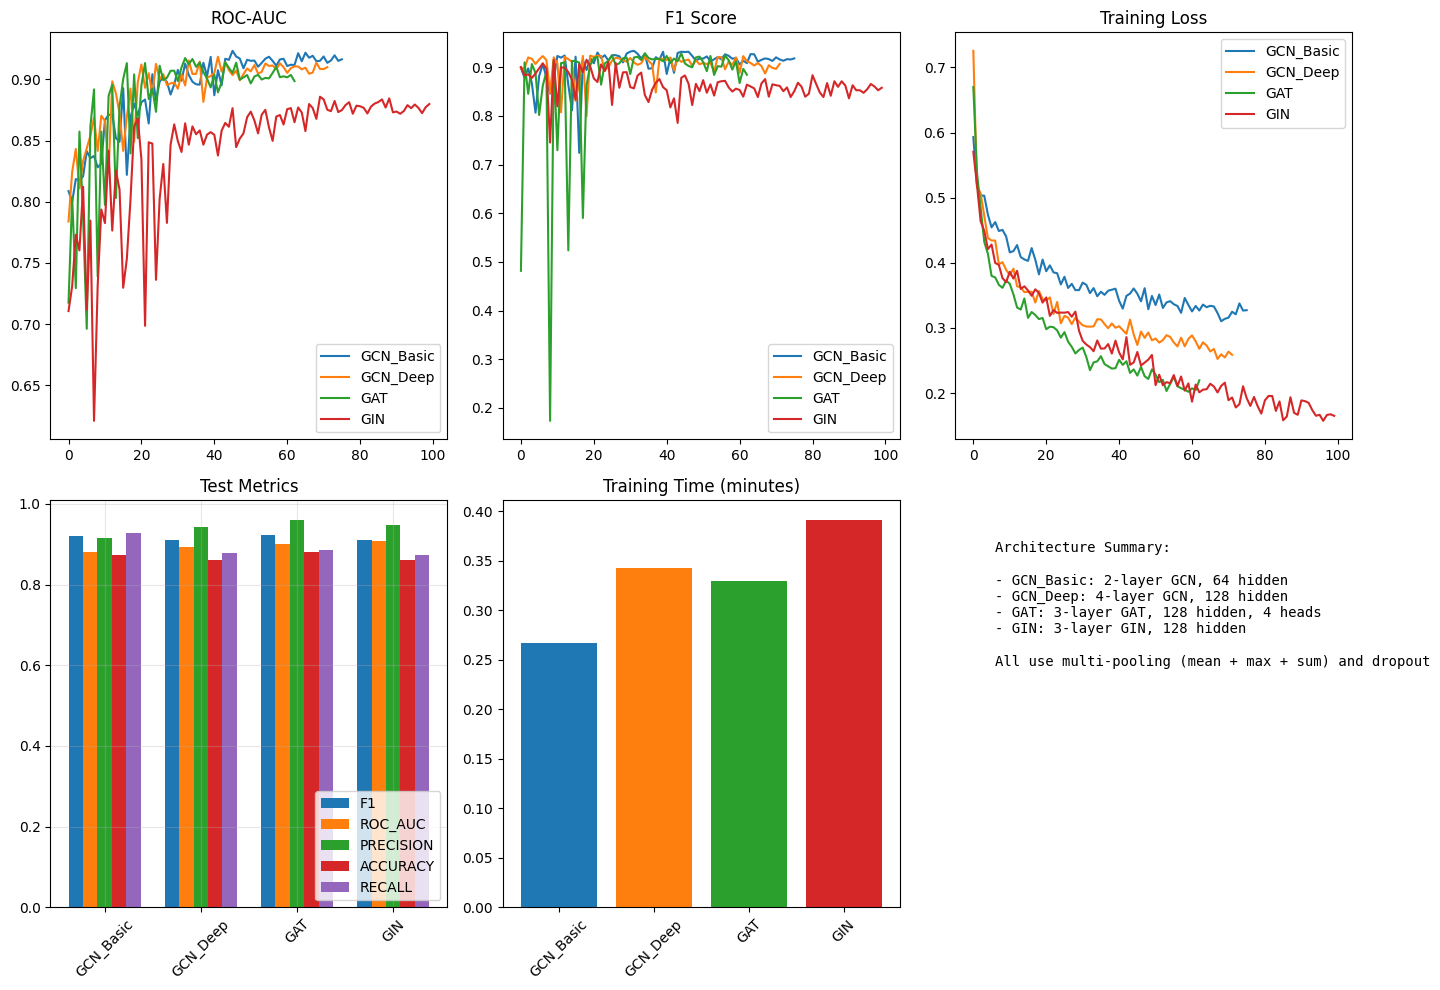


FINAL RESULTS SUMMARY

GCN_Basic:
  F1        : 0.9215
  Roc_auc   : 0.8798
  Accuracy  : 0.8730
  Precision : 0.9160
  Recall    : 0.9271
  Training Time: 0.27 min

GCN_Deep:
  F1        : 0.9099
  Roc_auc   : 0.8939
  Accuracy  : 0.8599
  Precision : 0.9435
  Recall    : 0.8785
  Training Time: 0.34 min

GAT:
  F1        : 0.9221
  Roc_auc   : 0.9014
  Accuracy  : 0.8795
  Precision : 0.9605
  Recall    : 0.8866
  Training Time: 0.33 min

GIN:
  F1        : 0.9095
  Roc_auc   : 0.9088
  Accuracy  : 0.8599
  Precision : 0.9474
  Recall    : 0.8745
  Training Time: 0.39 min

Best Model: GIN (ROC-AUC: 0.9088)


In [11]:


# LOAD DATASET 
from torch_geometric.datasets import MoleculeNet
dataset = MoleculeNet(root='./data', name='BBBP')


print(f"Number of node features: {dataset.num_node_features}")
print(f"Number of edge features: {dataset.num_edge_features}")
print(f"Number of classes: {dataset.num_classes}")

dataset = dataset.shuffle()

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = dataset[:train_size]
val_dataset = dataset[train_size:train_size + val_size]
test_dataset = dataset[train_size + val_size:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# MODELS 
class EnhancedGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=3, dropout_rate=0.3, use_attention=False):
        super(EnhancedGNN, self).__init__()
        self.use_attention = use_attention
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        if use_attention:
            self.convs.append(GATConv(input_dim, hidden_dim, heads=4, concat=False))
        else:
            self.convs.append(GCNConv(input_dim, hidden_dim))
        self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        for _ in range(num_layers - 1):
            if use_attention:
                self.convs.append(GATConv(hidden_dim, hidden_dim, heads=4, concat=False))
            else:
                self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_dim * 3, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc_out = nn.Linear(hidden_dim // 2, 1)

    def forward(self, x, edge_index, batch):
        x = x.float()
        edge_index = edge_index.long()
        for i, (conv, bn) in enumerate(zip(self.convs, self.batch_norms)):
            x_new = F.relu(bn(conv(x, edge_index)))
            x_new = self.dropout(x_new)
            x = x + x_new if i > 0 and x.size(-1) == x_new.size(-1) else x_new
        
        # Multi-scale graph-level pooling (mean + max + sum)
        x1 = global_mean_pool(x, batch)  # Average node features
        x2 = global_max_pool(x, batch)   # Max node features  
        x3 = global_add_pool(x, batch)   # Sum node features
        x = torch.cat([x1, x2, x3], dim=1)  # Concatenate all pooling results
        
        # Final classification layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc_out(x)  # Raw logits for BCEWithLogitsLoss

class GINGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=3, dropout_rate=0.3):
        super(GINGNN, self).__init__()
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        for i in range(num_layers):
            mlp = nn.Sequential(
                nn.Linear(input_dim if i == 0 else hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            )
            self.convs.append(GINConv(mlp))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_dim * 3, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc_out = nn.Linear(hidden_dim // 2, 1)

    def forward(self, x, edge_index, batch):
        x = x.float()
        for conv, bn in zip(self.convs, self.batch_norms):
            x = F.relu(conv(x, edge_index))
            x = bn(x)
            x = self.dropout(x)

        x1 = global_mean_pool(x, batch)
        x2 = global_max_pool(x, batch)
        x3 = global_add_pool(x, batch)
        x = torch.cat([x1, x2, x3], dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc_out(x)

# TRAINING FUNCTIONS 
def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = loss_fn(out, batch.y.view(-1, 1).float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate_model(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch).view(-1)
            probs = torch.sigmoid(out).cpu().numpy()
            labels = batch.y.cpu().numpy()
            all_preds.extend(probs)
            all_labels.extend(labels)
    binary_preds = [1 if p > 0.5 else 0 for p in all_preds]
    return {
        'f1': f1_score(all_labels, binary_preds),
        'roc_auc': roc_auc_score(all_labels, all_preds),
        'accuracy': accuracy_score(all_labels, binary_preds),
        'precision': precision_score(all_labels, binary_preds),
        'recall': recall_score(all_labels, binary_preds)
    }, all_preds, all_labels

# MODEL TRAINING WITH EARLY STOPPING 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

models_to_test = {
    'GCN_Basic': EnhancedGNN(input_dim=dataset.num_node_features, hidden_dim=64, num_layers=2, use_attention=False),
    'GCN_Deep': EnhancedGNN(input_dim=dataset.num_node_features, hidden_dim=128, num_layers=4, use_attention=False),
    'GAT': EnhancedGNN(input_dim=dataset.num_node_features, hidden_dim=128, num_layers=3, use_attention=True),
    'GIN': GINGNN(input_dim=dataset.num_node_features, hidden_dim=128, num_layers=3)
}

results = {}

for model_name, model in models_to_test.items():
    print(f"\n Training {model_name}...")
    model = model.to(device)
    # Using Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5)
    loss_fn = nn.BCEWithLogitsLoss()

    train_losses = []
    val_metrics_history = {'f1': [], 'roc_auc': [], 'accuracy': [], 'precision': [], 'recall': []}
    best_val_auc = 0
    patience_counter = 0
    patience_limit = 30
    best_epoch = 0
    start_time = time.time()

    for epoch in range(1, 302):
        train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device)
        train_losses.append(train_loss)
        val_metrics, _, _ = evaluate_model(model, val_loader, device)

        for metric_name, value in val_metrics.items():
            val_metrics_history[metric_name].append(value)

        scheduler.step(val_metrics['roc_auc'])

        if val_metrics['roc_auc'] > best_val_auc:
            best_val_auc = val_metrics['roc_auc']
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            best_epoch = epoch
        else:
            patience_counter += 1

        if patience_counter >= patience_limit:
            print(f"   Early stopping at epoch {epoch} (Best epoch: {best_epoch})")
            break

    model.load_state_dict(best_model_state)
    test_metrics, test_preds, test_labels = evaluate_model(model, test_loader, device)

    results[model_name] = {
        'test_metrics': test_metrics,
        'val_history': val_metrics_history,
        'train_losses': train_losses,
        'training_time': (time.time() - start_time) / 60
    }

    print(f"   {model_name} Test ROC-AUC: {test_metrics['roc_auc']:.4f} (Best epoch: {best_epoch})")

# PLOTTING 
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
for model_name in results:
    plt.plot(results[model_name]['val_history']['roc_auc'], label=model_name)
plt.title('ROC-AUC')
plt.legend()

plt.subplot(2, 3, 2)
for model_name in results:
    plt.plot(results[model_name]['val_history']['f1'], label=model_name)
plt.title('F1 Score')
plt.legend()

plt.subplot(2, 3, 3)
for model_name in results:
    plt.plot(results[model_name]['train_losses'], label=model_name)
plt.title('Training Loss')
plt.legend()

plt.subplot(2, 3, 4)
x = np.arange(len(results))
width = 0.15
metrics = ['f1', 'roc_auc', 'precision','accuracy', 'recall']
for i, metric in enumerate(metrics):
    vals = [results[k]['test_metrics'][metric] for k in results]
    plt.bar(x + i*width, vals, width, label=metric.upper())
plt.xticks(x + width*2, list(results.keys()), rotation=45)
plt.title('Test Metrics')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
times = [results[k]['training_time'] for k in results]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
plt.bar(list(results.keys()), times, color=colors)
plt.title('Training Time (minutes)')
plt.xticks(rotation=45)

plt.subplot(2, 3, 6)
plt.axis('off')
txt = "Architecture Summary:\n\n"
txt += "- GCN_Basic: 2-layer GCN, 64 hidden\n"
txt += "- GCN_Deep: 4-layer GCN, 128 hidden\n"
txt += "- GAT: 3-layer GAT, 128 hidden, 4 heads\n"
txt += "- GIN: 3-layer GIN, 128 hidden\n"
txt += "\nAll use multi-pooling (mean + max + sum) and dropout"
plt.text(0.1, 0.9, txt, fontfamily='monospace', verticalalignment='top')

plt.tight_layout()
plt.show()

# FINAL RESULTS 
print("\nFINAL RESULTS SUMMARY")
for model_name in results:
    print(f"\n{model_name}:")
    for k, v in results[model_name]['test_metrics'].items():
        print(f"  {k.capitalize():<10}: {v:.4f}")
    print(f"  Training Time: {results[model_name]['training_time']:.2f} min")

best_model = max(results, key=lambda m: results[m]['test_metrics']['roc_auc'])
print(f"\nBest Model: {best_model} (ROC-AUC: {results[best_model]['test_metrics']['roc_auc']:.4f})")



<small><i>The ROC AUC scores for all the models are very close and good.\
This means all of them perform well in distinguishing between the two classes.\
Here I used Early Stopping (based on validation ROC-AUC) to stop the training when parameter updates no longer begin to yield improves on a validation set.

<small><i>